<a href="https://colab.research.google.com/github/Kkuntal990/CTW_2020/blob/master/AE_trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import tensorflow as tf
import numpy as np
import os
import h5py
import pandas as pd
import time
import matplotlib.pyplot as plt


In [2]:
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LeakyReLU, Input, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Flatten
from keras.regularizers import l1,l2

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:

def load_unlabelled2(path):
    f = h5py.File(path, 'r')
    '''
    H_Re = f['H_Re'][:] #shape (sample size, 56, 924, 5)
    H_Im = f['H_Im'][:] #shape (sample size, 56, 924, 5)
    SNR  = f['SNR'][:]  #shape (sample size, 56, 5)
    print(SNR.shape)
    '''
  
    print(f.keys())
    H = f['h_Estimated'][:]
    f.close()
    return H


def load_unlabelled3(path):
    f = h5py.File(path, 'r')
    '''
    H_Re = f['H_Re'][:] #shape (sample size, 56, 924, 5)
    H_Im = f['H_Im'][:] #shape (sample size, 56, 924, 5)
    SNR  = f['SNR'][:]  #shape (sample size, 56, 5)
    print(SNR.shape)
    '''
  
    print(f.keys())
    H = f['r_Position'][:]
    f.close()
    return H


def load_unlabelled(path):
    f = h5py.File(path, 'r')
    '''
    H_Re = f['H_Re'][:] #shape (sample size, 56, 924, 5)
    H_Im = f['H_Im'][:] #shape (sample size, 56, 924, 5)
    SNR  = f['SNR'][:]  #shape (sample size, 56, 5)
    print(SNR.shape)
    '''
  
    print(f.keys())
    H = f['SNR_Est'][:]
    f.close()
    return H

In [5]:
H = load_unlabelled2('/content/drive/My Drive/CTW_2019/h_Estimated_CTW_Train.h5')
pos = load_unlabelled3('/content/drive/My Drive/CTW_2019/r_Position_CTW_Train.h5')

<KeysViewHDF5 ['h_Estimated']>
<KeysViewHDF5 ['r_Position']>


In [6]:
SNR = load_unlabelled('/content/drive/My Drive/CTW_2019/SNR_CTW_Train.h5')

<KeysViewHDF5 ['SNR_Est']>


In [7]:
print(H.shape)
print(pos.shape)
print(SNR.shape)
Y = np.swapaxes(pos, 0,1)
print(Y.shape)
H1 = np.swapaxes(H,0,3)
print(H1.shape)
print(H[:,1:10,1,1])
print(H1[1,1:10,1,:])

(2, 924, 16, 17486)
(3, 17486)
(16, 17486)
(17486, 3)
(17486, 924, 16, 2)
[[0.03866516 0.03544508 0.03482855 0.03706137 0.0372574  0.04047269
  0.0408036  0.03858153 0.04033941]
 [0.0078049  0.00788109 0.00903631 0.00951842 0.00666967 0.01102501
  0.01013644 0.01183    0.00960549]]
[[0.03866516 0.0078049 ]
 [0.03544508 0.00788109]
 [0.03482855 0.00903631]
 [0.03706137 0.00951842]
 [0.0372574  0.00666967]
 [0.04047269 0.01102501]
 [0.0408036  0.01013644]
 [0.03858153 0.01183   ]
 [0.04033941 0.00960549]]


In [0]:
def create_model():
    inp = Input(shape=(2,16,924))
    x = Dense(256, activation='relu',activity_regularizer=l1(10e-4))(inp)
  #  x = Dense(128, activation='relu')(x)
    encoded = Dense(64, activation='relu',activity_regularizer=l1(10e-4))(x)
  #  x = Dense(128, activation='relu')(encoded)
    x = Dense(256, activation='relu',activity_regularizer=l1(10e-4))(encoded)
    decoded = Dense(924, activation='relu')(x)
    return Model(inp, encoded), Model(inp, decoded)


In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(H1, test_size=0.1, random_state=42, shuffle=True)
y_train,y_test = train_test_split(Y, test_size=0.1, random_state=42, shuffle=True)

print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)


(15737, 924, 16, 2) (1749, 924, 16, 2)
(15737, 3) (1749, 3)


In [10]:
X_train = np.swapaxes(X_train,1,3)
print(X_train.shape)
print(H1[1,1:10,1,:])
print(np.swapaxes(H1,1,3)[1,:,1,1:10])

(15737, 2, 16, 924)
[[0.03866516 0.0078049 ]
 [0.03544508 0.00788109]
 [0.03482855 0.00903631]
 [0.03706137 0.00951842]
 [0.0372574  0.00666967]
 [0.04047269 0.01102501]
 [0.0408036  0.01013644]
 [0.03858153 0.01183   ]
 [0.04033941 0.00960549]]
[[0.03866516 0.03544508 0.03482855 0.03706137 0.0372574  0.04047269
  0.0408036  0.03858153 0.04033941]
 [0.0078049  0.00788109 0.00903631 0.00951842 0.00666967 0.01102501
  0.01013644 0.01183    0.00960549]]


In [30]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adadelta, Adam, RMSprop


H_comp, H_decod = create_model()

H_decod.compile(optimizer='Adam', loss = 'mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience = 20)
checkpointer = ModelCheckpoint('/content/drive/My Drive/CTW_2019/SimpleAE.h5', verbose=1, save_best_only=True)
H_decod.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2, 16, 924)        0         
_________________________________________________________________
dense_5 (Dense)              (None, 2, 16, 256)        236800    
_________________________________________________________________
dense_6 (Dense)              (None, 2, 16, 64)         16448     
_________________________________________________________________
dense_7 (Dense)              (None, 2, 16, 256)        16640     
_________________________________________________________________
dense_8 (Dense)              (None, 2, 16, 924)        237468    
Total params: 507,356
Trainable params: 507,356
Non-trainable params: 0
_________________________________________________________________


In [0]:
H_decod.fit(X_train, X_train, epochs = 150, verbose=1, batch_size = 32,validation_split=0.1, callbacks = [checkpointer,early_stopping])

In [17]:
model = load_model('/content/drive/My Drive/CTW_2019/SimpleAE.h5')
DL_input = Input(model.layers[0].input_shape[1:])
DL_model = DL_input
for layer in model.layers[1:3]:
    DL_model = layer(DL_model)
DL_model = Model(inputs=DL_input, outputs=DL_model)
DL_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2, 16, 924)        0         
_________________________________________________________________
dense_17 (Dense)             (None, 2, 16, 256)        236800    
_________________________________________________________________
dense_18 (Dense)             (None, 2, 16, 64)         16448     
Total params: 253,248
Trainable params: 253,248
Non-trainable params: 0
_________________________________________________________________


In [20]:
X_comp = DL_model.predict(X_train)
print(X_comp.shape)

(15737, 2, 16, 64)


In [49]:
Xt = model.predict(X_test)
print(np.sqrt(np.sum((Xt-X_test)**2)))
Xt_comp = DL_model.predict(X_test)

273.626228119075


In [26]:
X_comp = np.swapaxes(X_comp, 1,3)
Xt = np.swapaxes(Xt,1,3)
print(X_comp.shape)
print(Xt.shape)

(15737, 64, 16, 2)
(1749, 924, 16, 2)


In [28]:
def cnn2d():
  inp = Input(shape=(64,16,2))
  x = Conv2D(16, (3,3), padding="same",activation='relu')(inp)
  x = AveragePooling2D(pool_size=(4,1))(x)
  x =Dropout(0.25)(x)
  x = Conv2D(8, (3,3), padding="same",activation='relu')(x)
  x = AveragePooling2D(pool_size=(4,1))(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(64,activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(32,activation='relu')(x)
  x  = Dropout(0.2)(x)
  out = Dense(3)(x)

  
  return Model(inp,out)



classify = cnn2d()
classify.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 64, 16, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 16, 16)        304       
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         1160      
_________________________________________________________________
average_pooling2d_2 (Average (None, 4, 16, 8)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 16, 8)          0   

In [0]:
opt = RMSprop(learning_rate=0.001, decay=1e-6)
classify.compile(loss='mean_squared_error',optimizer=opt)
early_stopping = EarlyStopping(monitor='val_loss', patience = 20)
checkpointer = ModelCheckpoint('/content/drive/My Drive/CTW_2019/SimpleAE_pred.h5', verbose=1, save_best_only=True)

classify.fit(X_comp, y_train,
              batch_size=32,
              epochs=1000,
              validation_split=0.12,
              shuffle=True, callbacks=[early_stopping, checkpointer])



In [0]:
def rmse(p1, p2):
  return np.sqrt(np.sum((p1-p2)**2, axis = 1))

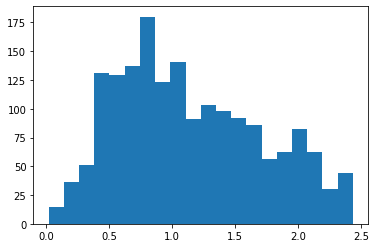

(array([  1.,   0.,   0.,   0.,   3.,   3.,   1.,   7.,   6.,  19.,  19.,
         25.,  87., 141., 173., 267., 254., 259., 246., 238.]),
 array([-3.90588658, -3.66605947, -3.42623235, -3.18640523, -2.94657811,
        -2.70675099, -2.46692388, -2.22709676, -1.98726964, -1.74744252,
        -1.50761541, -1.26778829, -1.02796117, -0.78813405, -0.54830694,
        -0.30847982, -0.0686527 ,  0.17117442,  0.41100154,  0.65082865,
         0.89065577]),
 <a list of 20 Patch objects>)

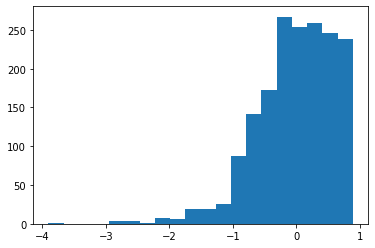

In [51]:
m2 = load_model('/content/drive/My Drive/CTW_2019/SimpleAE_pred.h5')
tt = m2.predict(np.swapaxes(Xt_comp,1,3))
#print(tt)
#print(y_test)
gg  = (rmse(tt,y_test))


plt.hist(gg, bins=20)
plt.show()
plt.hist(np.log(gg), bins=20)